In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from scipy.interpolate import CubicSpline


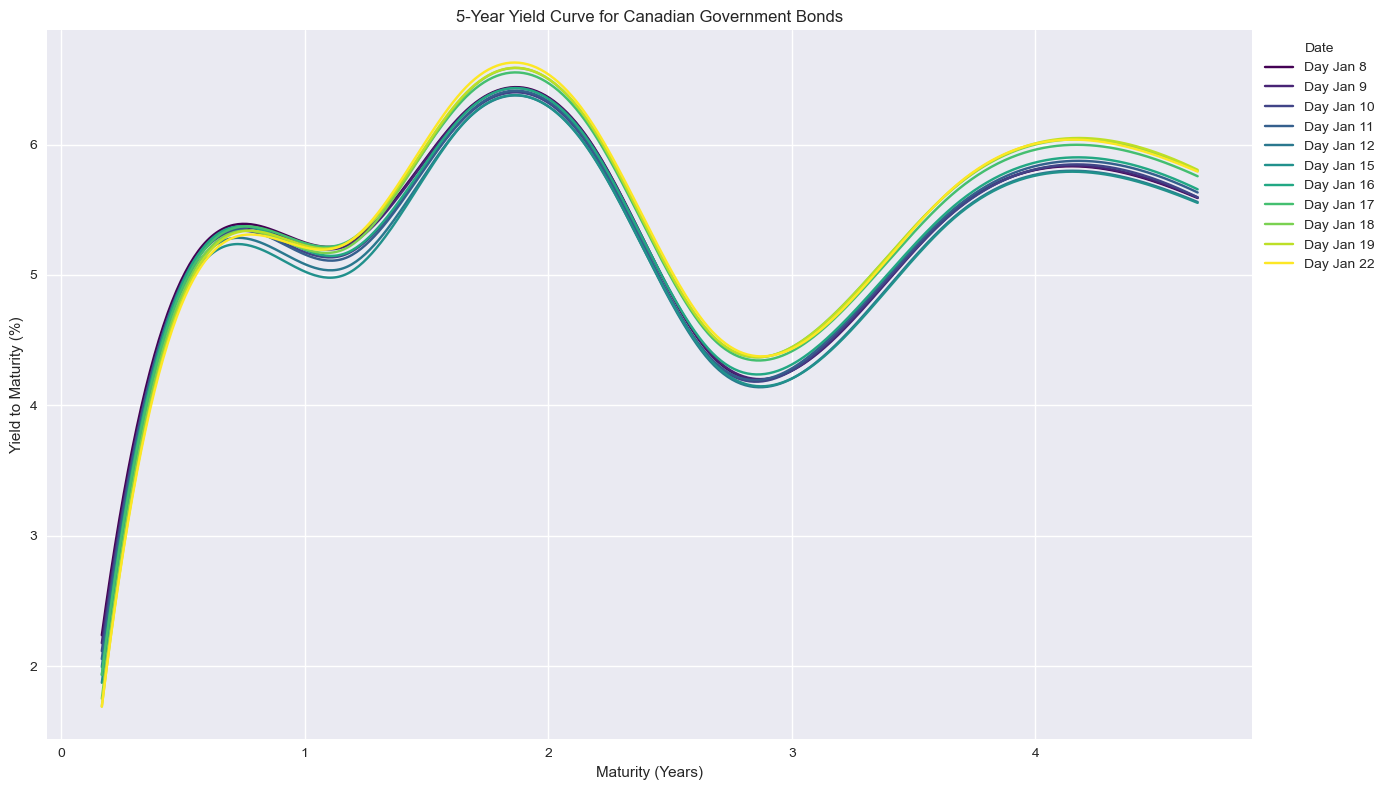

In [8]:
# Bond prices, terms, coupons, and days provided
bond_prices = np.array([
    [99.63, 99.64, 99.65, 99.66, 99.67, 99.69, 99.68, 99.68, 99.71, 99.72, 99.72],
    [97.96, 97.98, 97.99, 97.98, 98.02, 98.05, 97.97, 97.98, 98, 98.01, 98.03],
    [96.46, 96.48, 96.55, 96.58, 96.66, 96.72, 96.54, 96.45, 96.5, 96.46, 96.46],
    [98.19, 98.20, 98.26, 98.25, 98.31, 98.31, 98.21, 98.02, 97.98, 97.97, 97.9],
    [98.27, 98.28, 98.37, 98.35, 98.43, 98.44, 98.3, 98.05, 98, 97.99, 97.93],
    [93.46, 93.44, 93.55, 93.53, 93.6, 93.57, 93.4, 93.12, 93.08, 93.07, 93],
    [93.28, 93.30, 93.25, 93.19, 93.47, 93.49, 93.14, 92.86, 92.75, 92.76, 92.83],
    [97.58, 97.59, 97.6, 97.52, 97.74, 97.77, 97.44, 97.09, 96.96, 96.95, 96.94],
    [100.5, 100.48, 100.44, 100.33, 100.64, 100.67, 100.22, 99.83, 99.66, 99.62, 99.67],
    [99.74, 99.72, 99.72, 99.55, 99.88, 99.91, 99.44, 98.99, 98.81, 98.77, 98.83]
]).transpose()
terms = np.array([1/6 + i*0.5 for i in range(10)])  # Terms in years
coupons = np.array([0.0225, 0.015, 0.0125, 0.03, 0.03, 0.01, 0.0125, 0.0275, 0.0350, 0.0325]) * 100  # Coupons in currency units
days = ["Jan 8", "Jan 9", "Jan 10", "Jan 11", "Jan 12", "Jan 15", "Jan 16", "Jan 17", "Jan 18", "Jan 19", "Jan 22"]


In [ ]:
# Function to calculate YTM
def ytm(price, coupon, years_to_maturity, face_value=100, guess=0.05):
    def price_func(ytm):
        return sum([coupon / (1 + ytm / 2) ** (2 * t) for t in range(1, int(years_to_maturity * 2) + 1)]) + face_value / (1 + ytm / 2) ** (2 * years_to_maturity) - price
    return newton(price_func, guess)

# Calculate YTM for each bond for each day
ytms = np.array([[ytm(price, coupon, term) for price, coupon, term in zip(day_prices, coupons, terms)] for day_prices in bond_prices])

# Plotting
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(bond_prices)))
for i, (ytm_day, color) in enumerate(zip(ytms, colors)):
    cs = CubicSpline(terms, ytm_day)
    xs = np.linspace(terms[0], terms[-1], 500)
    ys = cs(xs)
    plt.plot(xs, ys * 100, label=f"Day {days[i]}", color=color)  # Convert YTM to percentage

plt.title("5-Year Yield Curve for Canadian Government Bonds")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (%)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# we use this package for solving our yield curve equation simpler
from sympy import Eq, solve, exp
from sympy.abc import r

In [ ]:
bond_prices = np.array([
              [99.63,99.64,99.65,99.66,99.67,99.69,99.68,99.68,99.71,99.72,99.72],
              [97.96,97.98,97.99,97.98,98.02,98.05,97.97,97.98,98,98.01,98.03],
              [96.46,96.48,96.55,96.58,96.66,96.72,96.54,96.45,96.5,96.46,96.46],
              [98.19,98.20,98.26,98.25,98.31,98.31,98.21,98.02,97.98,97.97,97.9],
              [98.27,98.28,98.37,98.35,98.43,98.44,98.3,98.05,98,97.99,97.93],
              [93.46,93.44,93.55,93.53,93.6,93.57,93.4,93.12,93.08,93.07,93],
              [93.28,93.30,93.25,93.19,93.47,93.49,93.14,92.86,92.75,92.76,92.83],
              [97.58,97.59,97.6,97.52,97.74,97.77,97.44,97.09,96.96,96.95,96.94],
              [100.5,100.48,100.44,100.33,100.64,100.67,100.22,99.83,99.66,99.62,99.67],
              [99.74,99.72,99.72,99.55,99.88,99.91,99.44,98.99,98.81,98.77,98.83],
              ]).transpose()  # each row is a day's price
terms = [1/6 + i*0.5 for i in range(10)]  # we simplify the term by assuming today is Jan 1st
days = ["Jan 8", "Jan 9", "Jan 10", "Jan 11", "Jan 12", "Jan 15", "Jan 16", "Jan 17", "Jan 18", "Jan 19", "Jan 22"]
coupons = np.array([0.0225,0.015,0.0125,0.03,0.03,0.01,0.0125,0.0275,0.0350,0.0325])

In [ ]:
def get_spot_rate(dirty_prices, terms, coupons, DEBUG=False):
    # always assume only the first term is zero coupon bond
    rates = []
    for i, t in enumerate(terms):
      dp = dirty_prices[i]
      coup = coupons[i]
      coupon_payment = coup*100*0.5
      if i > 0:
        constant = sum(coupon_payment*exp(-past_r*past_t) for (past_r,past_t) in zip(rates, terms[:i]))
      else:
        constant = 0
      eqn = Eq(dp, constant + (100+coupon_payment)*exp(-r*t))
      solution = solve(eqn, r, dict=True)[0][r]
      rates.append(solution)
      if DEBUG:
        print(f"solving {dp} = {constant} + (100+{coupon_payment})*exp(-r*{t})")
        print(f"got solution = {solution}")
    return rates

In [ ]:
# DEBUG with the class example
get_spot_rate(dirty_prices=[101.5,103.88], terms=[0.25, 0.75], coupons=[0.04,0.06], DEBUG=True)

In [ ]:
all_rates = []
for i, day_price in enumerate(bond_prices):
    # we always assume today is Jan 1st, which is 122 days from Sep 1st.
    dirty_prices = day_price + 122/365 * coupons * 100
    rates = get_spot_rate(dirty_prices, terms, coupons)
    all_rates.append(rates)
    print(f"Log {days[i]}:")
    print(f"day price of 10 bonds: {day_price}")
    print(f"dirty price of 10 bonds: {dirty_prices}")
    print(f"spot rates for 10 terms: {rates}")
    print("#"*30)

In [ ]:
# plot the spot curve for each day
colors = ['#d6debf', '#bad3a8', '#9bc799', '#7db991', '#64a88d', '#53948c', '#467c89', '#3f6380', '#3b4a71', '#35325a', '#2b1e3e']
plt.style.use('seaborn')
plt.figure(figsize=(10,4), dpi=100)
for i, rates in enumerate(all_rates):
    plt.plot(terms, rates, label=f"{days[i]}", linewidth=1, color=colors[i])
plt.xlabel("Term (years)")
plt.ylabel("Spot rate (%)")
plt.title("Spot curve for 10 selected bonds")
plt.legend()
plt.show()


# Forward Rate

In [ ]:
def get_forward_rate(spot_rate, terms, base_index, forward_indices):
    # base index is the term you calculate forward rate on
    # forward indices are the term you will calculate the forward rate
    r_b = spot_rate[base_index]
    t_b = terms[base_index]
    forward_rates = []
    for i in forward_indices:
      r_a = spot_rate[i]
      t_a = terms[i]
      # f_r = (1+r_a)**t_a/(1+r_b)**t_b - 1
      # print(r_b, t_b, r_a, t_a)
      f_r = (r_a*(t_a-0)-r_b*(t_b-0)) / (t_a-t_b)
      forward_rates.append(f_r)
    return forward_rates

In [ ]:
forward_rates = []
base_index = 0 # 2 corresponds to 1/6 which is approximately 1st year
forward_indices = [2,4,6,8]
for i, spot_rate in enumerate(all_rates):
  forward_rate = get_forward_rate(spot_rate, terms, base_index, forward_indices)
  forward_rates.append(forward_rate)
  print(f"forward rate for {days[i]}: {forward_rate}")

In [ ]:
# plot the spot curve for each day
colors = ['#d6debf', '#bad3a8', '#9bc799', '#7db991', '#64a88d', '#53948c', '#467c89', '#3f6380', '#3b4a71', '#35325a', '#2b1e3e']
plt.style.use('seaborn')
plt.figure(figsize=(10,4), dpi=100)
for i, rates in enumerate(forward_rates):
    plt.plot([terms[k] for k in forward_indices], rates, label=f"{days[i]}", linewidth=1, color=colors[i])
plt.xlabel("Term (years)")
plt.ylabel("Forward rate (%)")
plt.title("Forward curve for 10 selected bonds")
plt.legend()
plt.show()

# Covariance Matrices

In [ ]:
import math
ytms = [list(ytm) for ytm in ytms]
print(ytms)
print(forward_rates)

In [ ]:
def rate_to_log_return(rates):
  # first transpose the rates
  rates_np = np.array(rates).T
  log_return = []
  for rate in rates_np:
    logr0 = math.log(rate[0])
    #print(logr0, rate)
    temp = [math.log(r) - logr0 for r in rate[1:]]
    log_return.append(temp)

  return log_return

def compute_covariance(log_return):
  log_return = np.array(log_return)
  return np.cov(log_return)

In [ ]:
ytms_log_return = rate_to_log_return(ytms)
forward_rates_log_return = rate_to_log_return(forward_rates)

In [ ]:
print(len(ytms_log_return))
# ignore the half years as we want X1...X5, hence
ytms_log_return = [ytms_log_return[2*i] for i in range(len(ytms_log_return)//2)]
print(len(ytms_log_return))

In [ ]:
ytms_log_return_cov = compute_covariance(ytms_log_return)
print(ytms_log_return_cov)

forward_rates_log_return_cov = compute_covariance(forward_rates_log_return)
print(forward_rates_log_return_cov)

# Eigenvalues and Eigenvectors

In [ ]:
def top5eigen(cov_matrix):
  # Calculate eigenvalues and eigenvectors
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

  # Sort the eigenvalues and eigenvectors by largest eigenvalue
  idx = eigenvalues.argsort()[::-1]   # indices for sorting in descending order
  sorted_eigenvalues = eigenvalues[idx]
  sorted_eigenvectors = eigenvectors[:,idx]

  # Take the first 5 (in this case, it's all of them since we only have 5)
  first_5_eigenvalues = sorted_eigenvalues[:5]
  first_5_eigenvectors = sorted_eigenvectors[:,:5]
  eigenvalues_sum = sum(eigenvalues)

  return first_5_eigenvalues, first_5_eigenvectors, eigenvalues_sum

In [ ]:

first_5_eigenvalues, first_5_eigenvectors, eigenvalues_sum = top5eigen(ytms_log_return_cov)
print(f"Top 5 eigenvalues: {first_5_eigenvalues}")
print(f"Top 5 relative percentage {list(100*first_5_eigenvalues/eigenvalues_sum)} %")
print(f"Top 5 eigenvectors: {first_5_eigenvectors}")

In [ ]:
first_5_eigenvalues, first_5_eigenvectors, eigenvalues_sum = top5eigen(forward_rates_log_return_cov)
print(f"Top 5 eigenvalues: {first_5_eigenvalues}")
print(f"Top 5 relative percentage {list(100*first_5_eigenvalues/eigenvalues_sum)} %")
print(f"Top 5 eigenvectors: {first_5_eigenvectors}")